In [26]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit

csv_path = "./CSV/"

In [27]:
def quad_func(x, a, c):
    return a*x**2 + c

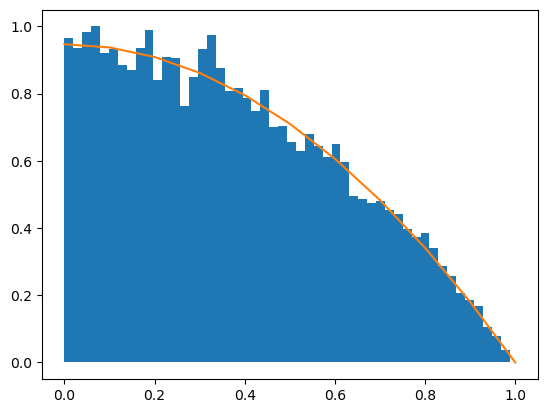

[-0.9482479   0.94713092]


In [28]:
quad_distrib_data = np.loadtxt(csv_path + "Ex2_1_quadratic_distr.csv", delimiter=",")

counts, bins = np.histogram(quad_distrib_data, 50)
counts = counts / np.max(counts)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

popt, pcov = curve_fit(quad_func, binscenters, counts)
x_fit = np.arange(0, 1.1, 0.1)

plt.hist(bins[:-1], bins, weights=counts)
plt.plot(x_fit, quad_func(x_fit, *popt))
plt.show()

print(popt)

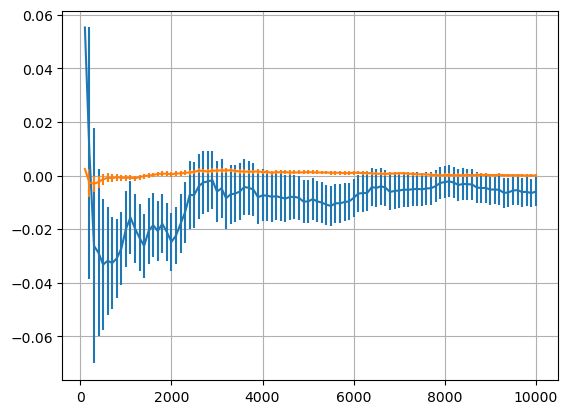

In [29]:
uniform_data = np.loadtxt(csv_path + "Ex2_1_uniform.csv", delimiter=",")
quad_data = np.loadtxt(csv_path + "Ex2_1_quad.csv", delimiter=",")

plt.errorbar(np.arange(1, 101, 1) * 100, uniform_data[:,0] - 1, yerr=uniform_data[:,1])
plt.errorbar(np.arange(1, 101, 1) * 100, quad_data[:,0] - 1, yerr=quad_data[:,1])
plt.grid(True)
plt.show()

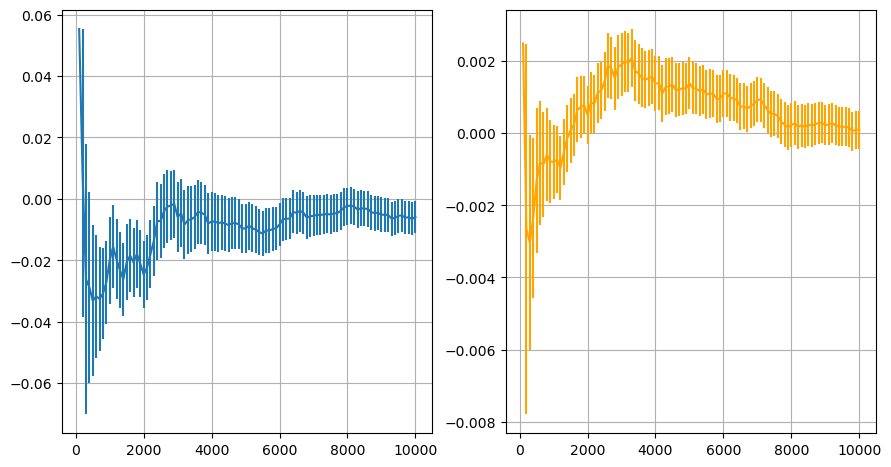

In [30]:
fig, axs = plt.subplots(1, 2)

axs[0].errorbar(np.arange(1, 101, 1) * 100, uniform_data[:,0] - 1, yerr=uniform_data[:,1])
axs[0].grid(True)
axs[1].errorbar(np.arange(1, 101, 1) * 100, quad_data[:,0] - 1, yerr=quad_data[:,1], color="orange")
axs[1].grid(True)
fig.set_size_inches(10.5, 5.5)
plt.show()

In [31]:
def sqrt_func(x, k):
    return k * np.sqrt(x)

[1.00290589]


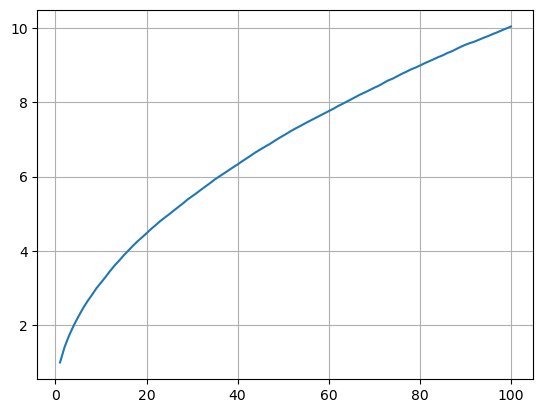

In [32]:
discrete_data = np.loadtxt(csv_path + "Ex2_2_discrete.csv", delimiter=",")

popt, pcov = curve_fit(sqrt_func, np.arange(1, 101, 1), np.sqrt(discrete_data))
print(popt)

plt.plot(np.arange(1, 101, 1), np.sqrt(discrete_data))
plt.grid(True)
plt.show()

[1.00165778]


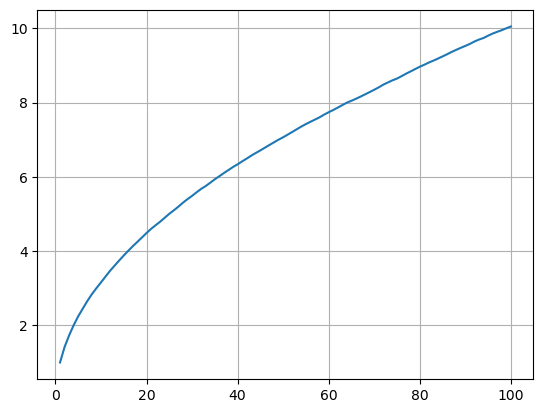

In [33]:
continue_data = np.loadtxt(csv_path + "Ex2_2_continue.csv", delimiter=",")

popt, pcov = curve_fit(sqrt_func, np.arange(1, 101, 1), np.sqrt(continue_data))
print(popt)

plt.plot(np.arange(1, 101, 1), np.sqrt(continue_data))
plt.grid(True)
plt.show()